In [48]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c
from astropy.io import fits
from photutils import DAOStarFinder, aperture_photometry, CircularAperture, CircularAnnulus
from astropy.stats import mad_std
import astroquery
from astropy import wcs
from astropy import table

In [18]:
#we need to specify the path for the data and where the output of the various files will be
path = '/Users/Rose/Documents/ASTR250/' #please reformat this for you
student = 'RoseKong/' #please put your name here
studentpath = '/Users/Rose/Documents/ASTR250/ICE14/'+student

In [19]:
def PrintStats(image):
    print('Min:',image.min())
    print('Max:',image.max())
    print('Median:',np.median(image))
    print('Std: ',np.std(image))
    return

def ShowImage(image,med=None,std=None,sigma=3,colorbar=True,vmin=None,vmax=None,stats=True,figsize=(8,8),show=True):
    if med==None:
        med = np.median(image)
    if std==None:
        std = np.std(image)
    plt.figure(figsize=figsize)
    if vmin == None:
        vmin=med-sigma*std
    if vmax == None:
        vmax=med+sigma*std
    #print('vmin',vmin,'vmax',vmax)
    if stats:
        PrintStats(image)
    plt.imshow(image,vmin=vmin,vmax=vmax,interpolation='none',cmap='gray_r',origin='lower')
    if colorbar:
        plt.colorbar()
    if show:
        plt.show()
    return

def MakeCutout(image,xc,yc,xsize,ysize):
    xcut = np.arange(xc-xsize,xc+xsize,dtype='int64')
    ycut = np.arange(yc-ysize,yc+ysize,dtype='int64')
    cutout = image_srcfind[xcut[0]:xcut[-1],ycut[0]:ycut[-1]]
    return cutout

`pyregion` https://pyregion.readthedocs.io/en/latest/index.html does not appear to support writing ds9 region files.

`region` http://astropy-regions.readthedocs.io/en/latest/ does, but it's super confusing.

In [20]:
def ds9circle(filename, ra, dec, radius=15):
    f = open(filename,'w')
    f.write('# Region file format: DS9 version 4.1\n')
    f.write('global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    f.write('fk5\n')
    for i in np.arange(ra):
        text = 'circle(%.3f,%.3f,%.0f\") \n' % (ra[i],dec[i],radius)
        f.write(text)
    f.close()
    return

Read the image and header from the FITS file.  Use the header information to construct a WCS (world coordinate system) object that will used (among other things) to convert pixel numbers to actual RA/Dec (and vice-versa).

In [21]:
datafile = path+'mthopkinsdata/data_processed.fits' #please change this to the directory where your processed image is
with fits.open(datafile) as hdu:
    image = hdu[0].data.copy()
    hdr = hdu[0].header.copy()
    w = wcs.WCS(hdr)
    # This works as well
    #w = wcs.WCS(datafile)

In [22]:
hdr

SIMPLE  =                    T                                                  
BITPIX  =                  -64 / 8 unsigned int, 16 & 32 int, -32 & -64 real    
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4096 /fastest changing axis                           
NAXIS2  =                 4096 /next to fastest changing axis                   
DATE-OBS= '2017-12-13T07:41:00' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   30.000000000000000 /Exposure time in seconds                        
EXPOSURE=   30.000000000000000 /Exposure time in seconds                        
SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -14.965013250000000 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.0000000000000000 /Pixel Width in microns (after binning)          
YPIXSZ  =   9.0000000000000000 /Pixel Height in microns (after binning)         
XBINNING=                   

In [23]:
image_srcfind = image
image_srcfind -= np.median(image_srcfind) 

Min: -216.001951389
Max: 38740.7049528
Median: 0.0
Std:  92.0194600299


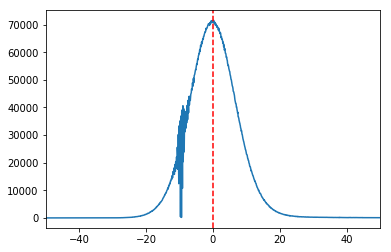

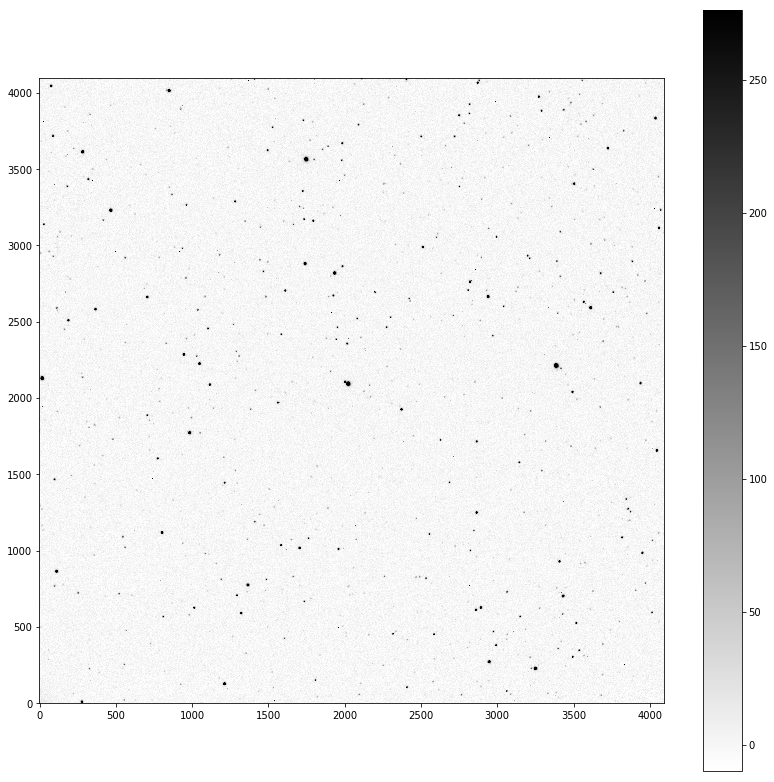

In [24]:
ShowImage(image_srcfind,figsize=(14,14),vmin=-10)

In [25]:
h,be = np.histogram(image_srcfind,bins='auto')
plt.plot(be[0:-1],h)
plt.axvline(0,color='red',linestyle='--')
plt.xlim([-50,50])

(-50, 50)

In [26]:
fwhm = 16.
bkg_sigma = mad_std(image_srcfind)   
#print(bkg_sigma)
daofind = DAOStarFinder(fwhm=fwhm, threshold=10.*bkg_sigma,roundlo=-0.25,roundhi=0.25)
# fluxand mag here are ... kind of not what you want
# Moreover, the remaining things are kind of checks on how well the source finding worked
sources = daofind(image_srcfind) 
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=fwhm)

In [27]:
phot_table = aperture_photometry(image, apertures)
ra, dec = w.all_pix2world(phot_table['xcenter'],phot_table['ycenter'],1)
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,5.2929799365099806,6.664209174190157,7079.15261286
2,1064.797422199534,4.672759218532077,1269.78245538
3,281.1587969273982,7.931863792234428,152255.179009
4,523.4761153263936,18.9258569087552,1025.13175097
5,558.0239936312439,18.853470843573724,12209.1889614
6,1316.9096447346672,26.77400277788645,4376.88715375
7,3403.1702075397757,34.97695198823589,3821.91299746
8,1823.7612792007403,40.425637095853645,6890.23445502


# Question 1
How can you add the RA and Dec to the astropy table below?

In [28]:
phot_table.sort('aperture_sum')
top5 = phot_table[-5:]
apertures_top5 = CircularAperture((top5['xcenter'],top5['ycenter']), r=fwhm)
top5
phot_table['RA'] = ra
phot_table['Dec'] = dec
phot_table

id,xcenter,ycenter,aperture_sum,RA,Dec
,pix,pix,,,
int32,float64,float64,float64,float64,float64
835,2594.290355175171,3782.630400061342,319.084372848,68.2526961642,58.7298545177
449,1371.2268326707592,2155.128966584341,492.200669215,68.0211531588,58.7301983473
251,3581.3243845645384,1163.85215053398,550.313052681,68.1924127155,58.7301884978
23,1941.6876112897687,91.58394442425872,654.810121646,68.1394689688,58.7315793777
858,601.567091221387,3878.4667727753804,673.790199534,68.1319185585,58.7315896684
329,3706.6674710887305,1545.0691139919554,727.681326159,67.9660648612,58.7327793504
777,3494.1173025053918,3579.0888465533235,748.308335429,67.5100519974,58.73336452
15,4014.2250885363023,63.1115610657196,852.25125903,67.8552842983,58.7343995051


We need a catalog where we can determine that magnitude of stars in our field to calibratio our images. For that we can use the AAVSO APASS catalog which has standard magnitudes for Johnson B and V filters as well as Sloan G', R' and I' filters. 

https://www.aavso.org/download-apass-data

In [29]:
# Calibrators
#note these values come from the AAVSO APASS Catalog

ra_cal = np.array([67.872588,68.153358,67.461229])
dec_cal = np.array([59.056575,59.096428,59.023264])
mag_cal = np.array([10.532,10.521,10.781])
mag_cal_error = np.array([0.019,0.041, 0.061])
x_cal,y_cal = w.all_world2pix(ra_cal,dec_cal,1)
apertures_cal = CircularAperture((x_cal,y_cal),r=fwhm*1.5)
print(x_cal)
print(y_cal)

[ 1746.3016831    475.50403161  3612.15192773]
[ 2879.58114933  3234.52571972  2590.74944193]


# Please plot the calibration stars in yellow, LW = 3, alpha = 1

Min: -216.001951389
Max: 38740.7049528
Median: 0.0
Std:  92.0194600299


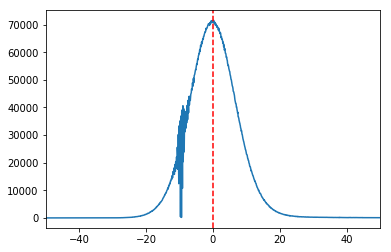

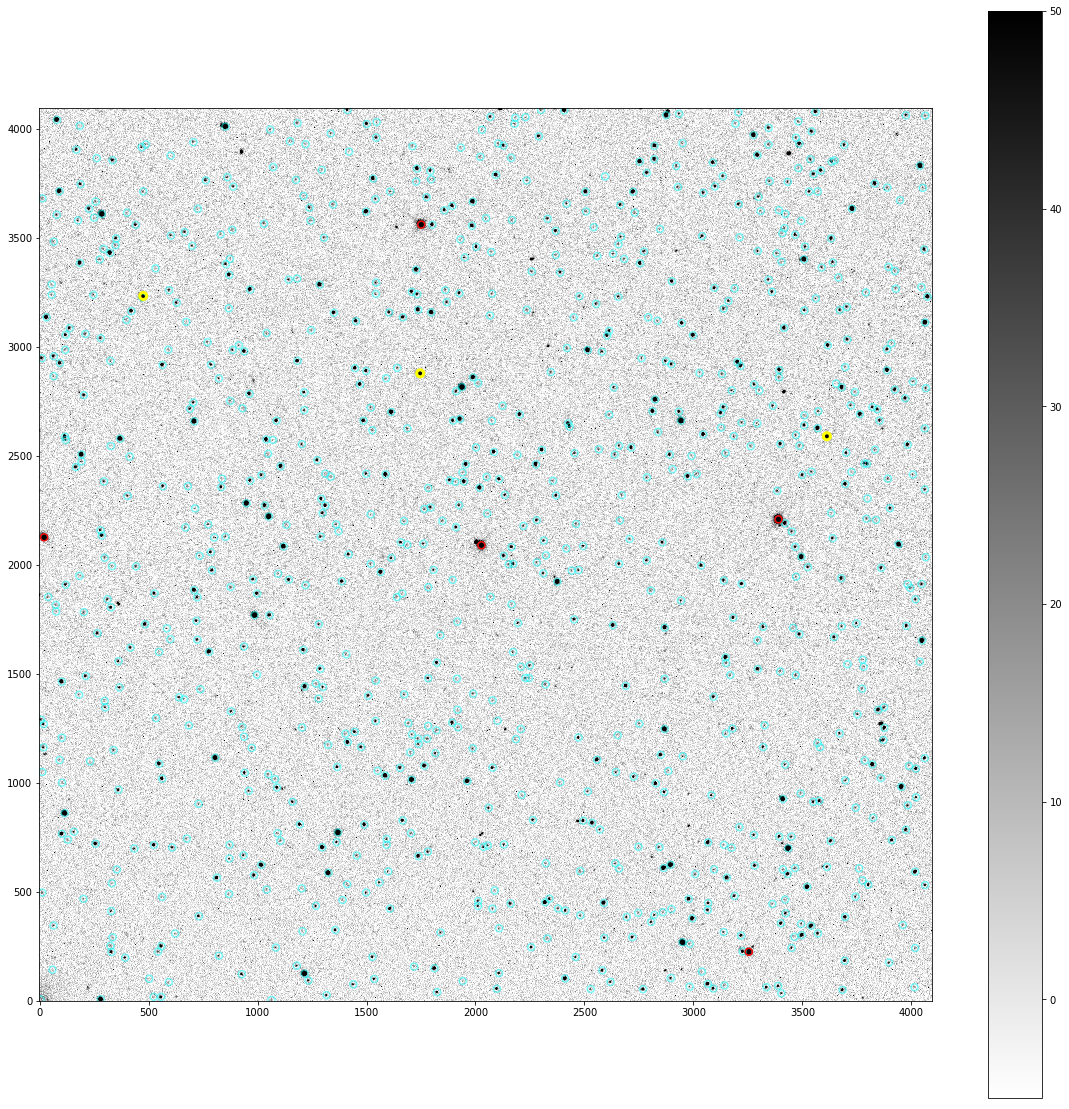

In [30]:
ShowImage(image_srcfind,figsize=(20,20),vmin=-5,vmax=50,show=False)
apertures.plot(color='cyan', lw=1.5, alpha=0.5)
apertures_top5.plot(color='red', lw=1.5, alpha=1)
calib = [x_cal, y_cal]
apertures_calib = CircularAperture((x_cal, y_cal), r=fwhm)
apertures_calib.plot(color='yellow', lw=3, alpha=1)
#apertures_top5 = CircularAperture((top5['xcenter'],top5['ycenter']), r=fwhm)
#top5
#plt.xlim([500,600])
#plt.ylim([500,600])
plt.show()

In [31]:
ra_cal

array([ 67.872588,  68.153358,  67.461229])

In [32]:
# Now we need to find which source in the list is the calibrator
def Nearest(x_target,y_target,x_cat,y_cat):
    pixdist = np.sqrt(np.power(x_target-x_cat,2)+np.power(y_target-y_cat,2))
    return np.argmin(pixdist)

You will need to figure out how to insert the RA and Dec into your table before the following code will work

In [33]:
ncal = len(x_cal)
whcal = []
for i in np.arange(ncal):
    whcal.append(Nearest(x_cal[i],y_cal[i],phot_table['xcenter'].value,phot_table['ycenter'].value))
    print('Calibrator %i' % i)
    print('Catalog %.5f %.5f' % (ra_cal[i],dec_cal[i]))
    print('Image %.5f %.5f' % (phot_table[whcal[i]]['RA'],phot_table[whcal[i]]['Dec']))

Calibrator 0
Catalog 67.87259 59.05658
Image 67.62270 59.19070
Calibrator 1
Catalog 68.15336 59.09643
Image 67.37905 59.18999
Calibrator 2
Catalog 67.46123 59.02326
Image 68.24179 59.18778


Solve for the constant necessary to make the magnitude correct
\begin{equation}
m_{cal} = -2.5*\log_{10}(aperture\_sum/F_0)
\end{equation}
\begin{equation}
10^{-m_{cal}/2.5} = aperture\_sum/F_0
\end{equation}
\begin{equation}
F_0 = 10^{m_{cal}/2.5} \times aperture\_sum
\end{equation}

In [35]:
def CalConst(m_cal,ap_sum):
    return ap_sum * np.power(10.,m_cal/2.5)

In [36]:
mag_cal

array([ 10.532,  10.521,  10.781])

In [37]:
ncal

3

In [67]:
F0 = CalConst(mag_cal[0],phot_table[whcal[0]]['aperture_sum'])
F1 = CalConst(mag_cal[1],phot_table[whcal[1]]['aperture_sum'])
F2 = CalConst(mag_cal[2],phot_table[whcal[2]]['aperture_sum'])
for i in np.arange(ncal):
    print('Calibrator %i' % i)
    image_cal = -2.5*np.log10(phot_table[whcal[i]]['aperture_sum']/F0)
    print('Catalog %.3f Image %.3f Difference %.3f' % (mag_cal[i],image_cal,mag_cal[i]-image_cal))
    
m_cal = (-2.5*np.log10(top5['aperture_sum'][2]/F0))
m_cal1 = (-2.5*np.log10(top5['aperture_sum'][2]/F1))
m_cal2 = (-2.5*np.log10(top5['aperture_sum'][2]/F2))

print(m_cal)#base
print(m_cal1) #calibrator
print(m_cal2) #calibrator
#very slightly different

Calibrator 0
Catalog 10.532 Image 10.532 Difference 0.000
Calibrator 1
Catalog 10.521 Image 10.542 Difference -0.021
Calibrator 2
Catalog 10.781 Image 10.796 Difference -0.015
8.84512949664
8.82426120167
8.83053960518


In [68]:
#F0 = CalConst(mag_cal[2],phot_table[whcal[1]]['aperture_sum'])
#for i in np.arange(ncal):
#    print('Calibrator %i' % i)
#    image_cal = -2.5*np.log10(phot_table[whcal[i]]['aperture_sum']/F0)
#    print('Catalog %.3f Image %.3f Difference %.3f' % (mag_cal[i],image_cal,mag_cal[i]-image_cal))

### Question 3

In [77]:
for i in range(3):
    print('Calibrator %i' % i)
    print((mag_cal[i]-image_cal) - mag_cal_error)

Calibrator 0
[-0.28258989 -0.30458989 -0.32458989]
Calibrator 1
[-0.29358989 -0.31558989 -0.33558989]
Calibrator 2
[-0.03358989 -0.05558989 -0.07558989]


The second and third elements of this array is the magnitude with regards to the first element.
For example, the first list consists of the Calibrator 0 star, and then the two stars with respect to calibrator star 0.

In [25]:
#if you already have the column m_ip inserted into your phototable, you will need to remove it before adding it again
#phot_table.remove_column('m_ip')

In [57]:
phot_table.add_column(table.Column(name='m_ip',data=-2.5*np.log10(phot_table['aperture_sum']/F0)))

In [69]:
phot_table


id,xcenter,ycenter,aperture_sum,RA,Dec,m_ip
,pix,pix,,,,
int32,float64,float64,float64,float64,float64,float64
835,2594.290355175171,3782.630400061342,319.084372848,68.2526961642,58.7298545177,18.7269391346
449,1371.2268326707592,2155.128966584341,492.200669215,68.0211531588,58.7301983473,18.2563474729
251,3581.3243845645384,1163.85215053398,550.313052681,68.1924127155,58.7301884978,18.135178438
23,1941.6876112897687,91.58394442425872,654.810121646,68.1394689688,58.7315793777,17.9464145129
858,601.567091221387,3878.4667727753804,673.790199534,68.1319185585,58.7315896684,17.9153912481
329,3706.6674710887305,1545.0691139919554,727.681326159,67.9660648612,58.7327793504,17.8318498971
777,3494.1173025053918,3579.0888465533235,748.308335429,67.5100519974,58.73336452,17.8015015153
15,4014.2250885363023,63.1115610657196,852.25125903,67.8552842983,58.7343995051,17.6602838438


# Question 4 
On a semilogy plot please make a historgram of the magnitudes. 

In [28]:
print('Brightest star: ',np.nanmin(phot_table['m_ip']))
print('Faintest star: ',np.nanmax(phot_table['m_ip']))

Brightest star:  8.56332515201
Faintest star:  18.4732175381


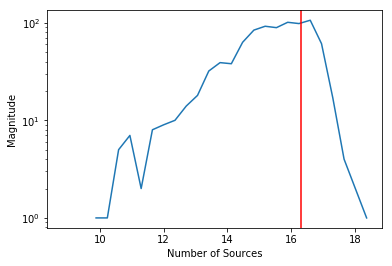

In [71]:
hi, mip = np.histogram(phot_table['m_ip'], bins = 'auto')
plt.semilogy(mip[0:-1], hi)
plt.xlabel("Number of Sources")
plt.ylabel("Magnitude")
plt.axvline(16.3, color='red')

plt.show()

There are many more sources of lower magnitude than those of higher magnitude. This tells us that the MINERVA-Red telescope with a 30 second exposure in the $i'$ band picks up many more sources of lower magnitude than high.

## Question 5

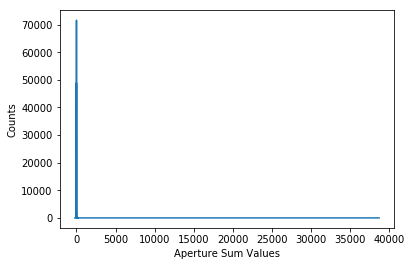

In [73]:
h,be = np.histogram(image_srcfind,bins='auto')
plt.plot(be[0:-1],h)
plt.xlabel('Aperture Sum Values')
plt.ylabel('Counts')

plt.show()

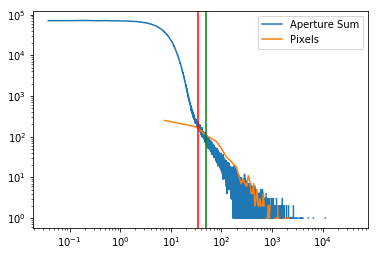

In [81]:
peak = sources['peak']
h2,b2 = np.histogram(phot_table['aperture_sum']/(np.pi*((fwhm/2.35)**2)), bins='auto')
h3, be3 = np.histogram(peak, bins='auto')
plt.loglog(be[:-1], h, label= 'Aperture Sum')
plt.loglog(be3[:-1], h3, label='Pixels')
plt.axvline(5.*bkg_sigma, color='red')
plt.axvline(7.*bkg_sigma, color='green')
plt.legend()
plt.show()

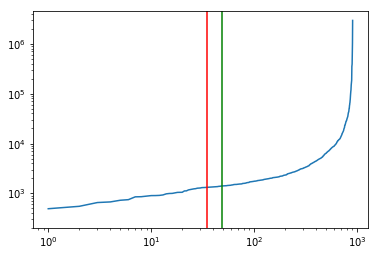

In [80]:
apsum = np.histogram(phot_table['aperture_sum'], bins ='auto')
plt.loglog(phot_table['aperture_sum'])
plt.axvline(5.*bkg_sigma, color='red')
plt.axvline(7.*bkg_sigma, color='green')
plt.show()

It tells us that there the aperture sum and pixel values increase with the number of sigmas. 

In [76]:
#plt.loglog(be[:-1], h, label = 'Pixel val')
#h_apsum, be_apsum = np.histogram(phot_table['aperture_sum']/apertures.area(), bins = 'auto')
#plt.loglog(be_apsum[:-1], h_apsum, label='Source mean pixel')
#plt.show()